# Generating recordings with specific ADC depth and LSB

This notebook shows how to generate recordings that mimic an acquisition system with a certain ADC bit depth (number of bits used by the Analog to Digital Converter) and LSB (least significant bit).

With MEArec, when selecting an `int` dtype, we can specify the number of bits needed to encode the input signal.
In addition, we can also specify the value of the LSB in the output recording.


The ADC bit depth and LSB controls the final range of the signal:

```
signal_range = lsb * (2^adc_bit_depth)
```

Note that if LSB and ADC bit depth are too large they might exceed the value ranges allowed by the dtype (e.g. `int16`). In this case, you can try to define a *deeper* dtype (e.g. `int32`).

In [1]:
import MEArec as mr
import MEAutility as mu
import yaml
import numpy as np
from pprint import pprint
import matplotlib.pylab as plt
%matplotlib notebook

## Load default configuration files

First, let's load the default configuration of MEArec

In [2]:
default_info, mearec_home = mr.get_default_config()
pprint(default_info)

{'cell_models_folder': '/home/alessio/.config/mearec/1.7.2/cell_models/bbp',
 'recordings_folder': '/home/alessio/.config/mearec/1.7.2/recordings',
 'recordings_params': '/home/alessio/.config/mearec/1.7.2/default_params/recordings_params.yaml',
 'templates_folder': '/home/alessio/.config/mearec/1.7.2/templates',
 'templates_params': '/home/alessio/.config/mearec/1.7.2/default_params/templates_params.yaml'}


## Load pre-generated templates

In [3]:
tempgen = mr.load_templates('data/test_templates.h5')

## Generating and saving recordings with different ADC depths and LSBs

We assume that the `data/test_templates.h5` templates has already been generated (run `generate_templates_and_recordings.ipynb` notebook first).

In [4]:
recordings_params = mr.get_default_recordings_params()
pprint(recordings_params)

{'cell_types': {'excitatory': ['PC', 'SS', 'SP'],
                'inhibitory': ['AC',
                               'BP',
                               'BC',
                               'BTC',
                               'ChC',
                               'DBC',
                               'MC',
                               'NGC']},
 'recordings': {'adc_bit_depth': None,
                'angle_tol': 15,
                'bursting': False,
                'bursting_units': None,
                'chunk_duration': 0,
                'color_noise_floor': 1,
                'color_peak': 300,
                'color_q': 2,
                'drift_mode': 'slow',
                'drifting': False,
                'dtype': 'float32',
                'exp_decay': 0.2,
                'extract_waveforms': False,
                'far_neurons_exc_inh_ratio': 0.8,
                'far_neurons_max_amp': 10,
                'far_neurons_n': 300,
                'far_neurons_noise_floor'

Similarly to the templates generation, we can change th eparameters that we pass to the `gen_recordings` function.
In this case we will keep the default parameters.

In [7]:
adc_bit_depths = [10, 12]
lsbs = [1, 4, 8]

In [8]:
# set seeds for reproducibility
recordings_params["seeds"]["templates"] = 0
recordings_params["seeds"]["spiketrains"] = 1
recordings_params["seeds"]["convolution"] = 2
recordings_params["seeds"]["noise"] = 3

recordings_params["recordings"]["dtype"] = "int16"
recordings_params["recordings"]["filter"] = False

In [11]:
recgen_dict = {}
for adc_bit_depth in adc_bit_depths:
    for lsb in lsbs:
        print(f"\n\nADC DEPTH: {adc_bit_depth} -- LSB: {lsb}\n\n")
        recordings_params["recordings"]["adc_bit_depth"] = adc_bit_depth
        recordings_params["recordings"]["lsb"] = lsb

        recgen = mr.gen_recordings(templates='data/test_templates.h5', params=recordings_params)
        recgen_dict[f"adc{adc_bit_depth}_lsb{lsb}"] = recgen



ADC DEPTH: 10 -- LSB: 1


Loading templates...
Done loading templates...
Spiketrains seed:  1
dtype int16
ADC bit depth: 10 -- LSB: 1
Noise Level  10
Templates selection seed:  0
Selecting cells
Templates and noise scaled by gain: 2.409147255096658
Padding template edges
Elapsed pad time: 0.0761106014251709
Creating time jittering
Elapsed jitter time: 0.17703819274902344
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  2
Electrode modulaton
Adding noise
Noise seed:  3
Elapsed time:  0.9079455350001808


ADC DEPTH: 10 -- LSB: 4


Loading templates...
Done loading templates...
Spiketrains seed:  1
dtype int16
ADC bit depth: 10 -- LSB: 4
Noise Level  10
Templates selection seed:  0
Selecting cells
Templates and noise scaled by gain: 9.636589020386632
Padding template edges
Elapsed pad time: 0.07639288902282715
Creating time jittering
Elapsed jitter time: 0.17438435554504395
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  2
Electrode m

The `recgen` variable is a `RecordingGenerator` object. It contains the selected `templates`, `template_locations`, `template_rotations`, and `template_celltypes`, as well as `spiketrains` and `recordings`.

In [14]:
mr.save_recording_generator(recgen, "test_lsb.h5")
recgen_loaded = mr.load_recordings("test_lsb.h5")

In [15]:
recgen_loaded.gain_to_uV

0.012971394726449053

<IPython.core.display.Javascript object>


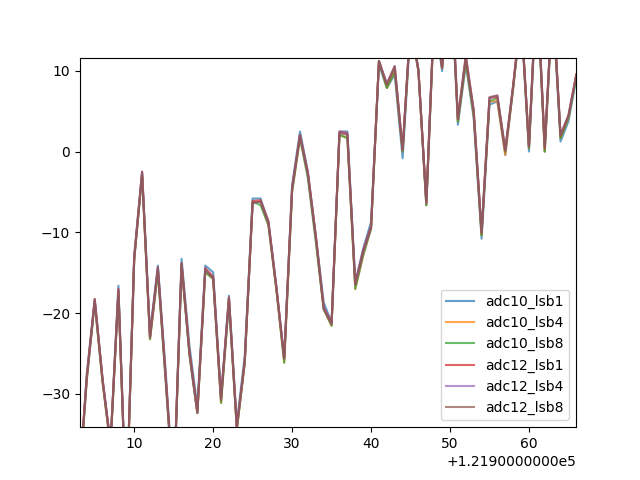

In [13]:
ch = 10
fig, ax = plt.subplots()

for i, (rec_name, recgen) in enumerate(recgen_dict.items()):
    ax.plot(recgen.recordings[:, ch] * recgen.gain_to_uV, color=f"C{i}", alpha=0.7, label=rec_name)
ax.legend()

In [ ]:
for i, (recgen, adc_bit_depth) in enumerate(zip(recgens, adc_bit_depths)):
    lsb = np.min(np.diff(np.sort(np.unique(recgen.recordings))))
    ptp_traces = np.ptp(recgen.recordings.astype("float"))
    nbits = int(np.ceil(np.log2(ptp_traces / lsb)))
    print(f"ADC depth", adc_bit_depth, "Nbits", nbits, "LSB", lsb)